<a href="https://colab.research.google.com/github/rahulsust/BDLensing/blob/main/week-5/lens_modeling_with_lenstronomy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:** Rahul Dev Sharma, Md. Mehedi Hasan

In [ ]:
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

In [ ]:
# import of standard python libraries
import lenstronomy
import numpy as np
import corner
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
with h5py.File('team_5_order_2.h5', 'r') as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]
with h5py.File('psf.h5', 'r') as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()] 
kwargs_psf['psf_type'] = 'PIXEL'

## Load imaging data and plot


<ipython-input-8-1b178849417d>:2: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_data), origin = 'lower', cmap = 'cubehelix');


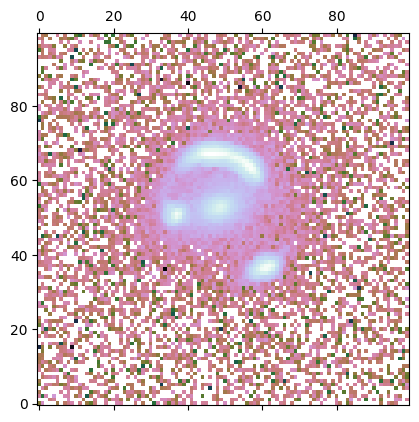

In [ ]:
image_data = kwargs_data['image_data']
plt.matshow(np.log10(image_data), origin = 'lower', cmap = 'cubehelix');

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

# Task
You need to add external shear to the `lens_model_list` with the profile name ‘SHEAR’. The free parameters in this profile are: ‘gamma1’ and ‘gamma2’, and the fixed parameters are ‘ra_0’: 0, ‘dec_0’: 0. The upper and lower values for ‘gamma1’ and ‘gamma2’ are 0.3 and -0.3. (lenstronomy documentation: https://lenstronomy.readthedocs.io/en/latest/lenstronomy.LensModel.Profiles.html#lenstronomy.LensModel.Profiles.shear.Shear) 
You need to add the ‘SHAPELETS’ light profile to the `source_model_list`. The free parameters are ‘beta’, ‘center_x’, and ‘center_y’. But, ‘center_x’ and ‘center_y’ needs to be joined with the ‘center_x’ and ‘center_y’ of the Sersic light profile in the `source_model_list`. The fixed parameter is ‘n_max’, you can try values between 4 and 6 for the fixed value of ‘n_max’. 


In [ ]:
lens_model_list = ['EPL', 'SHEAR']
source_model_list = ['SERSIC_ELLIPSE', 'SHAPELETS'] 
lens_light_model_list = ['SERSIC_ELLIPSE']

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [ ]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})
fixed_lens.append({'ra_0': 0, 'dec_0': 0})


kwargs_lens_init.append({'theta_E': 1., 'gamma': 2., 'e1': 0., 'e2': 0.,
                         'center_x': 0., 'center_y': 0.})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
                    


kwargs_lens_sigma.append({'theta_E': .2, 'gamma': .1, 'e1': 0.05, 'e2': 0.05,
                         'center_x': 0.5, 'center_y': 0.5})

kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})





kwargs_lower_lens.append({'theta_E': 0.01, 'gamma': 1., 'e1': -0.5,
                          'e2': -0.5, 'center_x': -10, 'center_y': -10})

kwargs_lower_lens.append({'gamma1': -0.3, 'gamma2': -0.3})




kwargs_upper_lens.append({'theta_E': 10., 'gamma': 3., 'e1': 0.5, 'e2': 0.5,
                          'center_x': 10, 'center_y': 10})

kwargs_upper_lens.append({'gamma1': 0.3, 'gamma2': 0.3})



lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, 
               kwargs_lower_lens, kwargs_upper_lens]


# lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({'n_sersic': 4.})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 
                               'e2': 0,'center_x': 0., 'center_y': 0, 
                               'amp': 16})

kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 
                                'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1,
                                'amp': 10})

kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
                                'n_sersic': .5, 'center_x': -10, 
                                'center_y': -10,'amp': 0})

kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 
                                'n_sersic': 5., 'center_x': 10, 
                                'center_y': 10, 'amp': 100})

joint_lens_with_light = [[0, 0, ['center_x', 'center_y', 'e1', 'e2']]]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, 
                     fixed_lens_light, kwargs_lower_lens_light,
                     kwargs_upper_lens_light]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({'n_sersic': 1.})

fixed_source.append({'n_max': 4}) 

kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 
                           'center_x': 0., 'center_y': 0, 'amp': 16})

kwargs_source_init.append({'beta': 3, 'center_x': 0, 'center_y': 0}) 

kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.5, 'e1': 0.05, 
                            'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2,
                            'amp': 10})

kwargs_source_sigma.append({'beta': 2, 'center_x': 0.2, 'center_y': 0.2}) 

kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 
                            'n_sersic': .5, 'center_x': -10, 'center_y': -10,
                            'amp': 0})

kwargs_lower_source.append({'beta': 0, 'center_x': -10, 'center_y': -10}) 

kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 
                            'n_sersic': 5., 'center_x': 10, 'center_y': 10,
                            'amp': 100})

kwargs_upper_source.append({'beta': 5, 'center_x': 10, 'center_y': 10})  

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source,
                 kwargs_lower_source, kwargs_upper_source]

joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]

# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}


kwargs_constraints = {'joint_lens_with_light': joint_lens_with_light, 
                      'joint_source_with_source' : joint_source_with_source}

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [ ]:
kwargs_likelihood = {'check_bounds': True}

kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False
                   }

#### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'joint-linear'
                    }

## Here the model fiting is done

In [ ]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood,
                              kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 200, 
                                'n_iterations': 100}]]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.191255617347458 reduced X^2 of best position
-5937.21799685973 log likelihood
9968 effective number of data points
[{'theta_E': 0.7582121230904638, 'gamma': 2.172455510230183, 'e1': 0.20234248619249226, 'e2': -0.12289272261824206, 'center_x': 0.06638037021435045, 'center_y': 0.12888333652837805}, {'gamma1': -0.023156315968353512, 'gamma2': 0.13417666178407298, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.10987034761300055, 'n_sersic': 1.0, 'e1': -0.03324803507254189, 'e2': 0.13334588311300163, 'center_x': -0.07003912013918595, 'center_y': 0.004561980449181621}, {'amp': 1, 'n_max': 4, 'beta': 0.031132980878300184, 'center_x': -0.07003912013918595, 'center_y': 0.004561980449181621}] source result
[{'amp': 1, 'R_sersic': 0.46795580412421756, 'n_sersic': 4.0, 'e1': 0.20234248619249226, 'e2': -0.12289272261824206, 'center_x': 0.06638037021435045, 'center_y': 0.12888333652837805}] lens l

## Visualizing the fitted model

-1.187443599371946 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.187443599371946


<ipython-input-28-51d71d795efa>:16: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


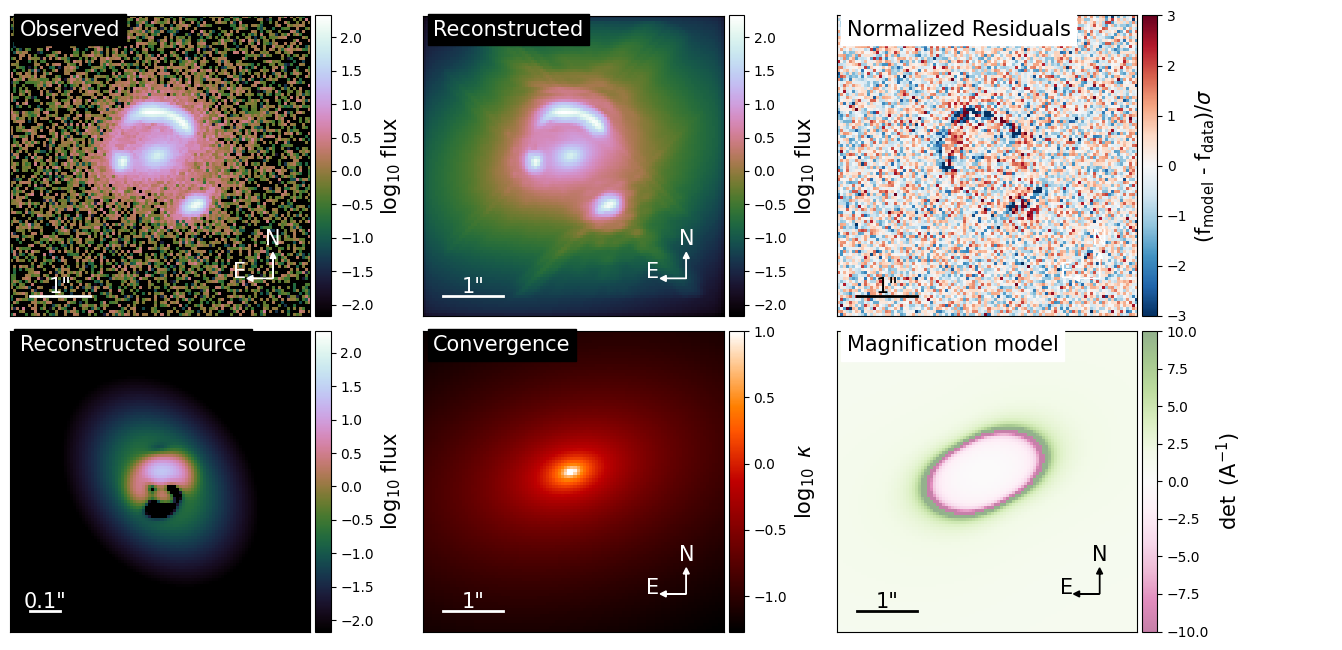

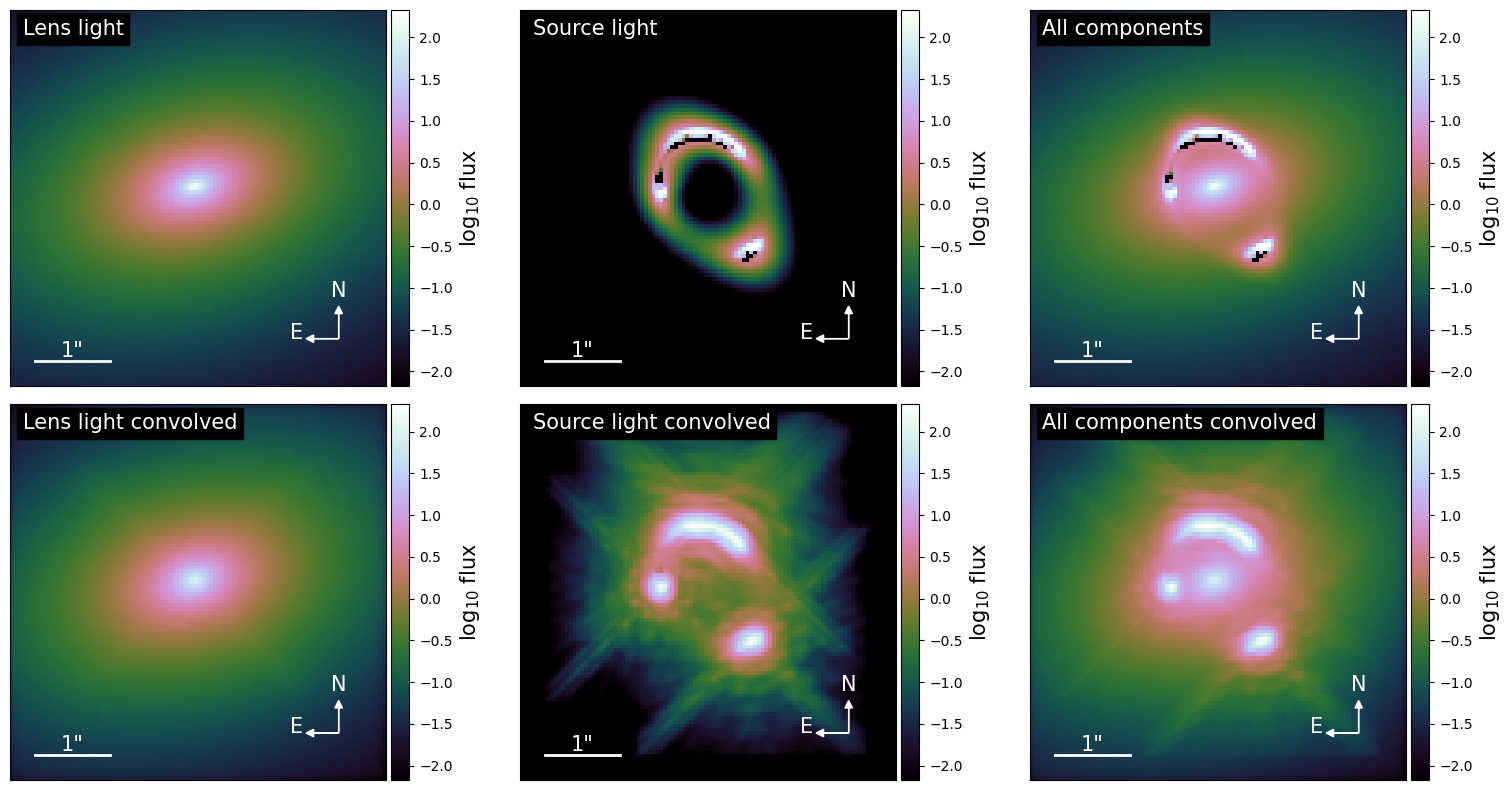

{'kwargs_lens': [{'theta_E': 0.7582121230904638, 'gamma': 2.172455510230183, 'e1': 0.20234248619249226, 'e2': -0.12289272261824206, 'center_x': 0.06638037021435045, 'center_y': 0.12888333652837805}, {'gamma1': -0.023156315968353512, 'gamma2': 0.13417666178407298, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 2067.670702979867, 'R_sersic': 0.10987034761300055, 'n_sersic': 1.0, 'e1': -0.03324803507254189, 'e2': 0.13334588311300163, 'center_x': -0.07003912013918595, 'center_y': 0.004561980449181621}, {'amp': array([233934.95317839, -25211.4594154 , 257692.50351216,  43446.87890408,
       -48298.76245578, 128493.56314671,  -5310.74582976,  30220.09109349,
       -21166.36286235,  -3737.77525021,  40318.49465074, -30465.44067626,
        10625.6024717 ,  -1246.85811145, -44900.32096374]), 'n_max': 4, 'beta': 0.031132980878300184, 'center_x': -0.07003912013918595, 'center_y': 0.004561980449181621}], 'kwargs_lens_light': [{'amp': 1533.9864871615496, 'R_sersic': 0.46795580412421756, 'n_s

In [ ]:
from lenstronomy.Plots.model_plot import ModelPlot

model_plot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, 
                      arrow_size=0.02, cmap_string="cubehelix",
                      )

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0,0])
model_plot.model_plot(ax=axes[0,1])
model_plot.normalized_residual_plot(ax=axes[0,2], v_min=-3, v_max=3,
                                   cmap='RdBu_r')
model_plot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap='gist_heat')
model_plot.magnification_plot(ax=axes[1, 2], cmap='PiYG')
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(ax=axes[0,0], text='Lens light', 
                             lens_light_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,0], text='Lens light convolved',
                             lens_light_add=True)
model_plot.decomposition_plot(ax=axes[0,1], text='Source light', 
                             source_add=True, unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,1], text='Source light convolved', 
                             source_add=True)
model_plot.decomposition_plot(ax=axes[0,2], text='All components',
                             source_add=True, lens_light_add=True,
                             unconvolved=True)
model_plot.decomposition_plot(ax=axes[1,2], text='All components convolved',
                             source_add=True, lens_light_add=True,
                             point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.,
                  hspace=0.05)
plt.show()
print(kwargs_result)